## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import os.path
from os import path
from collections import OrderedDict
import time

models_dir = os.path.expanduser('~/group/donut/medical_ip/trained_models')
model_name = 'model_resenet18_multi_class_multi_label_k_fold.pt'
model_path = os.path.join(models_dir, model_name)
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
print('Model save/load location: {}'.format(model_path))

Model save/load location: /home/pablo/group/donut/medical_ip/trained_models/model_resenet18_multi_class_multi_label_k_fold.pt


## Custom Dataset Loading Class

In [2]:
label_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation',
              'Infiltration','Fibrosis','Pneumonia','No Finding']

In [3]:
def resolve_full_path(img_name):
    is_found = False

    # Read 1 image file
    folder_idx_range = 13
    img_path = ''
    for folder_idx in range(folder_idx_range):
        path_prefix = path.expanduser("~/data/kaggle/nih-chest-xrays/data/images_")
        path_suffix = "images/"
        cur_img_dir = path_prefix +str(folder_idx).zfill(3) +'/'
        img_folder_path = path.join(cur_img_dir, path_suffix)
        img_path = os.path.join(img_folder_path, img_name)

        if(path.exists(img_path)):
            is_found = True
            break
    if(not is_found):
        
        raise Exception('Couldn\'t find: {} last:{}'.format(img_name, img_path))
    return img_path
        
class DatasetFromCSV(Dataset):
    def __init__(self, csv_path=None, data_frame=None, transform=None):
        if(csv_path is not None):
            self.data = pd.read_csv(csv_path).head(20)
        elif data_frame is not None:
            self.data = data_frame
        else:
            raise Exception('No csv path or data frame provided')

        self.data_len = len(self.data.index)            # csv data length
        
        self.image_names = np.array(self.data.iloc[:,0])  # image names
        self.heights = np.asarray(self.data.iloc[:,8])    # heights are at 8th column 
        self.widths =  np.asarray(self.data.iloc[:,7])    # widths are at  7th column
        
        # createa a tensor to store labels
        self.labels = torch.zeros(self.data_len, 15)
        labels = self.data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
        self.multi_hot_encoding_label(labels)
    
        self.transform = transform
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        # Read 1 image name
        img_name = self.image_names[index]
        img_path = resolve_full_path(img_name)
        img_as_img = Image.open(img_path)

        img_as_img = img_as_img.convert("RGB")
        # Transform image to tensor
        img_as_tensor = self.transform(img_as_img)

        # Read 1 label:
        image_label = self.labels[index]

        return img_as_tensor, image_label
    
    def multi_hot_encoding_label(self, labels):
            for i,label in enumerate(labels):
                for idx in range(len(label_list)):
                    if label_list[idx] in label:
                        self.labels[i][idx] = 1

## Resample imbalanced dataset

In [4]:
# Iterate through all_labels to calculate each case's weight
def calculate_weight(data):
    D_single_weight = calculate_single_label_weight(data)
    weight = torch.zeros(data.shape[0])
    
    all_labels = data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
    for i, labels in enumerate(all_labels):
        for ii, label in enumerate(labels):
            weight[i] += D_single_weight[label]
    
    return weight

def calculate_single_label_weight(data):
    # Calculate single label weight
    D_sorted = count_label(data)
    D_single_weight = D_sorted.copy()
    for i, label in enumerate(D_single_weight.keys()):
        D_single_weight[label] = 1.0/D_single_weight[label]*1e5
        
    return D_single_weight

def count_label(data):
    D_label_count = dict()
    all_labels = data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
    for i,labels in enumerate(all_labels):
        for ii, label in enumerate(labels):
            D_label_count[label] = D_label_count.get(label, 0) + 1
    D = D_label_count
    D_sorted = OrderedDict(sorted(D.items(), key=lambda x: x[1], reverse=True))
    
    return D_sorted

## Use dataloader to load data

In [5]:
# Define transforms
transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define custom data loader
train_dataset = DatasetFromCSV('~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/traindata_paul.csv',transform=transform)
valid_dataset = DatasetFromCSV('~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/valdata_paul.csv',transform=transform)
batch_size_ = 10

# Define sampler to resample the imbalanced dataset
train_dataset_entry = pd.read_csv("~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/traindata_paul.csv")
valid_dataset_entry = pd.read_csv("~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/valdata_paul.csv")

sample_weight = calculate_weight(train_dataset_entry)
print("sample weights shape: ", sample_weight.shape)
weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weight, batch_size_)


print("training dataset len:", len(train_dataset))
print("testing dataset len:", len(valid_dataset))

# Define two data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size_,
                                                num_workers=6,
                                                shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                batch_size=batch_size_,
                                                num_workers=6,
                                                shuffle=True)

print("train_loader len: ", len(train_loader))
print("test_loader len: ", len(valid_loader))

sample weights shape:  torch.Size([78534])
training dataset len: 20
testing dataset len: 20
train_loader len:  2
test_loader len:  2


## Show the loaded images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image batch shape:  torch.Size([10, 3, 224, 224])
single image shape:  torch.Size([3, 224, 224])
img_1channel shape:  (224, 224)
img_3channel shape: torch.Size([224, 224, 3])
labels: tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
label type: <class 'torch.Tensor'>


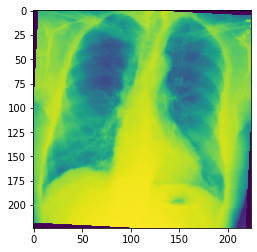

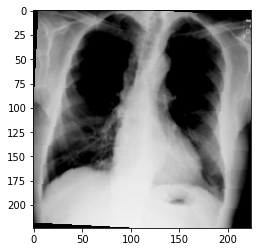

In [6]:
image, label = next(iter(train_loader))

print("\nimage batch shape: ", image.shape)
print("single image shape: ", image[9].shape)

# 1 channel image
img_1_channel = image.numpy()[9][1]
print("img_1channel shape: ", img_1_channel.shape)
plt.figure()
plt.imshow(img_1_channel)

# 3 channel image
plt.figure()
img_3_channel = image[9].permute(1, 2, 0)
plt.imshow(img_3_channel, cmap='cool')
print("img_3channel shape:", img_3_channel.shape)

# print label
print("labels:",label)
print("label type:",type(label))

In [7]:
# print label
image, label = next(iter(train_loader))

print("labels:",label)
print("label type:",type(label))

labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
label type: <class 'torch.Tensor'>


## Define the model with Transfer learning

In [ ]:
from torchvision import models

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ",device)

def create_model():
    
    # Import pre-trained densenet-121
    model = models.resnet18(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    # Change output to classfiy 14 conditioins + nothing.
    # Change a new classifier
    model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 15)
    )
    return model
model = create_model()
print(model)

### Specify Loss function and Optimizer

In [9]:


criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.001
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

model = model.to(device);
writer = SummaryWriter(f'run/k_fold_resnet18/training')


# Kfold prep

In [10]:
from sklearn.model_selection import KFold

# Define sampler to resample the imbalanced dataset
train_dataset_entry = pd.read_csv("~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/traindata_paul.csv")
valid_dataset_entry = pd.read_csv("~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/valdata_paul.csv")

n_splits = 5
kf = KFold(n_splits = n_splits, shuffle = True, random_state = 2)


non_test_set = pd.concat([train_dataset_entry, valid_dataset_entry], axis=0)


    

         Image Index         Finding Labels  Follow-up #  Patient ID  \
0   00000002_000.png             No Finding            0           2   
1   00000003_000.png                 Hernia            0           3   
2   00000003_001.png                 Hernia            1           3   
3   00000003_002.png                 Hernia            2           3   
4   00000003_003.png    Hernia|Infiltration            3           3   
5   00000003_004.png                 Hernia            4           3   
6   00000003_005.png                 Hernia            5           3   
7   00000003_006.png                 Hernia            6           3   
8   00000003_007.png                 Hernia            7           3   
9   00000004_000.png            Mass|Nodule            0           4   
10  00000005_000.png             No Finding            0           5   
11  00000005_001.png             No Finding            1           5   
12  00000005_002.png             No Finding            2        

## Train the model

In [ ]:
from torch.autograd import Variable

# number of epochs to train the model
n_epochs = 30
k =1
valid_losses = []
train_losses = []
for  train_index, valid_index in kf.split(non_test_set):
    train = non_test_set.iloc[train_index]
    valid =  non_test_set.iloc[valid_index]
    # Define custom data loader
    train_dataset = DatasetFromCSV(data_frame=train,transform=transform)
    valid_dataset = DatasetFromCSV(data_frame=valid,transform=transform)
    batch_size_ = 10
    # Define two data loaders
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                    batch_size=batch_size_,
                                                    num_workers=6,
                                                    shuffle=True)

    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                    batch_size=batch_size_,
                                                    num_workers=6,
                                                    shuffle=True)
    
    print('Fold: {}/{} '.format(k, n_splits,))
    # k fold setup before
    valid_loss_min = np.Inf # track change in validation loss
    writer.add_scalar('learning rate', learning_rate)
    for epoch in range(1, n_epochs+1):
        t0 = time.time()
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            model = model.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

            # Print losses ocassionally and print to tensorboard
            if batch_idx % 100 == 0:

                writer.add_scalar('loss', train_loss, batch_idx)
                with torch.no_grad():
                    img_grid_real = torchvision.utils.make_grid(data, normalize=True)
                    writer.add_image("Train Lung Xray Images", img_grid_real)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):

            data = data.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        t1 = time.time()
        total = t1-t0
        # print training/validation statistics 
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} Duration seconds: {}'.format(
            epoch, n_epochs, train_loss, valid_loss, total))
        writer.add_scalar('train_loss', train_loss, batch_idx)
        writer.add_scalar('valid_loss', valid_loss, batch_idx)


        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), model_path)
            valid_loss_min = valid_loss
        writer.add_scalar('best_valid_loss_fold', valid_loss_min, batch_idx)

    valid_losses.append(valid_loss_min)
    train_losses.append(train_loss)

print(valid_losses)

Fold: 1/5 
Epoch: 1/30 	Training Loss: 0.541545 	Validation Loss: 0.337093 Duration seconds: 1.2616312503814697
Validation loss decreased (inf --> 0.337093).  Saving model ...
Epoch: 2/30 	Training Loss: 0.252544 	Validation Loss: 0.307796 Duration seconds: 1.3222460746765137
Validation loss decreased (0.337093 --> 0.307796).  Saving model ...
Epoch: 3/30 	Training Loss: 0.237446 	Validation Loss: 0.353199 Duration seconds: 1.2399094104766846
Epoch: 4/30 	Training Loss: 0.246135 	Validation Loss: 0.341429 Duration seconds: 1.256216287612915
Epoch: 5/30 	Training Loss: 0.230725 	Validation Loss: 0.367726 Duration seconds: 1.2306718826293945
Epoch: 6/30 	Training Loss: 0.225789 	Validation Loss: 0.346221 Duration seconds: 1.3279964923858643
Epoch: 7/30 	Training Loss: 0.212140 	Validation Loss: 0.365496 Duration seconds: 1.5530097484588623
Epoch: 8/30 	Training Loss: 0.222464 	Validation Loss: 0.361588 Duration seconds: 1.5339789390563965
Epoch: 9/30 	Training Loss: 0.230507 	Validation 

# Test classficaton on a single image.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# Doing inference on cpu as it doesn't take much effort feel free to change.
# Had some trouble loading it on GPU. 
image, label = next(iter(valid_loader))
model = create_model()
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

data = image.to('cpu')
# forward pass: compute predicted outputs by passing inputs to the model
output = model(data)
output = output.to('cpu').detach().numpy()
target = label.to('cpu').detach().numpy()
cur = 7
print(np.shape(target))
print(np.shape(output))

print("Predicted: {}".format(output[cur]))
print("Predicted sigmoid: {}".format(sigmoid(output[cur])))

print("Actual: {}".format(target[cur]))

print("Predicted Max : {}".format(output[cur].max()))
print("Actual Max : {}".format(target[cur].max()))

print("Predicted Sigmoid Arg Max : {}".format(sigmoid(output[cur].argmax())))
print("Actual Arg Max : {}".format(target[cur].argmax()))


print(output[cur].max())
print("\nimage batch shape: ", image.shape)
print("single image shape: ", image[cur].shape)




# 1 channel image
img_1_channel = image.numpy()[cur][1]
print("img_1channel shape: ", img_1_channel.shape)
plt.figure()
plt.imshow(img_1_channel)

# 3 channel image
plt.figure()
img_3_channel = image[cur].permute(1, 2, 0)
plt.imshow(img_3_channel, cmap='cool')
print("img_3channel shape:", img_3_channel.shape)

# print label
print("labels:",label)
